# San Francisco Airbnb Price Prediction
The goal of this prediction is to help people who are new and possibly old to Airbnb help accurately price their housing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score 

## What the Data Looks Like

In [2]:
sf = pd.read_csv('../Data/AB_SF_2020.csv')
sf = sf.drop(columns=['id', 'host_id', 'host_name'])
sf = sf.drop(columns=['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude'])
sf = sf.drop(columns=['number_of_reviews', 'last_review', 'reviews_per_month'])
sf.head()

,name,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,"Bright, Modern Garden Unit - 1BR/1B",Entire home/apt,170,1,1,106
1,Creative Sanctuary,Entire home/apt,235,30,1,0
2,A Friendly Room - UCSF/USF - San Francisco,Private room,65,32,9,365
3,Friendly Room Apt. Style -UCSF/USF - San Franc...,Private room,65,32,9,365
4,Historic Alamo Square Victorian,Entire home/apt,703,5,2,365


## Data Preprocessing/Feature Extraction

### Name Length

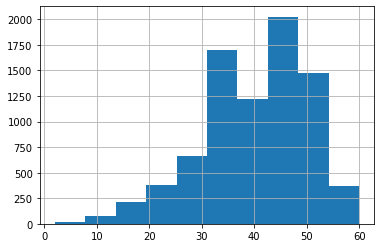

In [3]:
sf['name_length'] = sf['name'].map(str).apply(len)
sf['name_length'] = sf['name_length'].apply(lambda x: 60 if x > 60 else x)
sf = sf.drop(columns=['name'])

sf['name_length'].hist()

### Room Type

In [4]:
# room_to_num = {room:index for index, room in enumerate(sf['room_type'].unique())}
# sf['room_type'] = sf['room_type'].apply(lambda x: room_to_num[x])
# sf['room_type'].hist()

(array([2906.,    0.,    0.,    0.,    0., 4882.,    0.,    0.,    0.,
         263.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

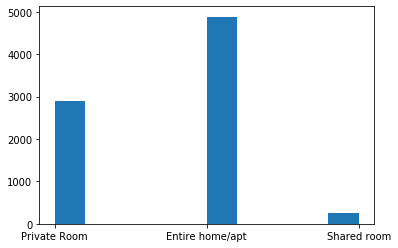

In [5]:
sf['rm_private'] = sf['room_type'].apply(lambda x: 0 if x != 'Private room' else 1)
sf['rm_entire'] = sf['room_type'].apply(lambda x: 0 if x != 'Entire home/apt' else 1)
sf['rm_shared'] = sf['room_type'].apply(lambda x: 0 if x != 'Shared room' else 1)
sf = sf.drop(columns=['room_type'])

sums = [sf['rm_private'].sum(), sf['rm_entire'].sum(), sf['rm_shared'].sum()]
plt.hist(x=['Private Room', 'Entire home/apt', 'Shared room'], weights=sums)

### Minimum Nights

Min Value 1
Max Value 100000000


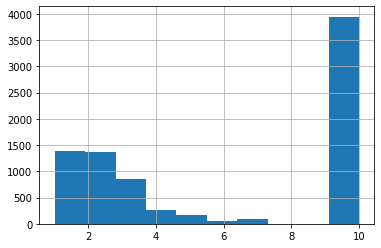

In [6]:
print('Min Value', sf['minimum_nights'].min())
print('Max Value', sf["minimum_nights"].max())

sf['minimum_nights'] = sf['minimum_nights'].apply(lambda x: 10 if x > 10 else x)
sf['minimum_nights'].hist()

### Calculated Host Listings Count

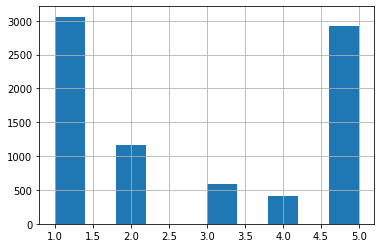

In [7]:
sf['calculated_host_listings_count'] = sf['calculated_host_listings_count'].apply(lambda x: 5 if x > 5 else x)
sf['calculated_host_listings_count'].hist()

### Availability 365

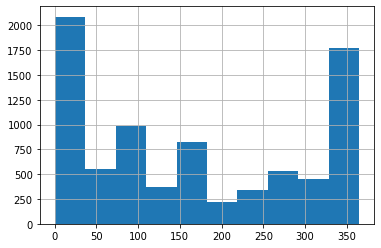

In [8]:
sf['availability_365'].hist()

## Feature Selection

### Feature Correlation

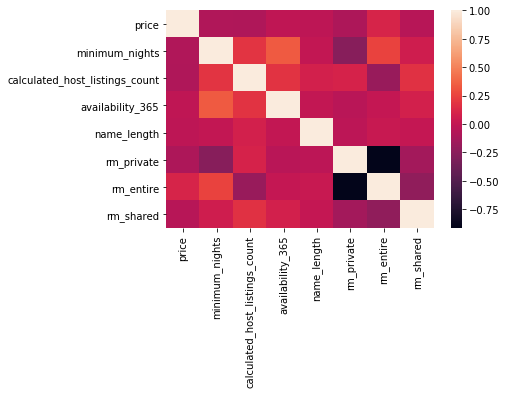

In [9]:
sns.heatmap(sf.corr())

### Feature Importance

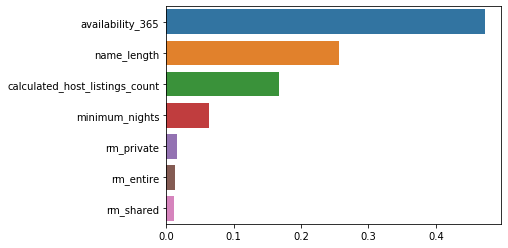

In [10]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(sf.drop(columns=['price']), sf['price'])

feature_imp = pd.Series(tree_reg.feature_importances_,index=sf.drop(columns=['price']).columns).sort_values(ascending=False)
%matplotlib inline
sns.barplot(x=feature_imp, y=feature_imp.index)

### Selecting Features and Splitting Data

In [11]:
sf_thresh = sf[sf['price'] < 350]
X, y = sf_thresh.drop(columns=['price']), sf_thresh['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Model Selection

### Decision Tree Regressor

In [12]:
tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(X_train, y_train)

tree_pred = tree_reg.predict(X_test)
tree_r2 = r2_score(y_test, tree_pred)
tree_mse = mean_squared_error(y_test, tree_pred)
tree_all_r2 = cross_val_score(estimator=tree_reg, X=tree_pred.reshape(-1, 1), y=y_test, cv=5)
print(tree_reg.score(X_train, y_train))
print(tree_all_r2.mean())
print(tree_r2)
print(tree_mse)

0.3685942433392947
0.3446742362413255
0.36658481106906116
3394.6002774676444


### Linear Regressor

In [13]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

linear_pred = linear_reg.predict(X_test)

linear_r2 = r2_score(y_test, linear_pred)
linear_mse = mean_squared_error(y_test, linear_pred)
linear_all_r2 = cross_val_score(estimator=linear_reg, X=linear_pred.reshape(-1, 1), y=y_test, cv=5)
print(linear_all_r2.mean())
print(linear_r2)
print(linear_mse)

0.3089166869220872
0.31543552662919394
3668.7196515939504


### Suport Vector Regressor

In [14]:
sv_reg = SVR(gamma='auto')
sv_reg.fit(X_train, y_train)

sv_pred = sv_reg.predict(X_test)
sv_r2 = r2_score(y_test, sv_pred)
sv_mse = mean_squared_error(y_test, sv_pred)
sv_all_r2 = cross_val_score(estimator=sv_reg, X=sv_pred.reshape(-1, 1), y=y_test, cv=5)
print(sv_all_r2.mean())
print(sv_reg.score(X_train, y_train))
print(sv_r2)
print(sv_mse)

0.024615492775275083
0.03545829314197302
0.014945980997077779
5279.103982131567
